In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [25]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated_avg")
df=data_df.loc[16:140,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd","churn","temp_deviation","price_range","price_gas_avg"]] 
print(df)


#start at 15 for churn
#first ets value at line 38

     months  price_gas  price_brent_gbp  open_interest_gas       lng  \
16   Feb 11  58.253804        70.022260            22565.0  1.990000   
17   Mar 11  65.671980        77.353399            19575.0  2.460000   
18   Apr 11  63.693670        79.431267            16590.0  2.680000   
19   May 11  61.265423        74.670881            19680.0  2.480000   
20   Jun 11  61.790899        75.892758            22840.0  2.020000   
..      ...        ...              ...                ...       ...   
136  Feb 21  40.967919        40.980074            41235.0  1.897236   
137  Mar 21  40.658930        43.494060            44325.0  2.321223   
138  Apr 21  46.712534        42.188306            37515.0  2.111904   
139  May 21  57.411172        43.616761            35298.0  1.428956   
140  Jun 21  64.147268        47.484969            35409.0  1.016736   

      storage  temperature     euas    supply   coal_gbp   eurgbp    gbpusd  \
16   0.200000         7.50  18.4450  8.010000  81.114294

In [26]:
#Vector:
dprice_gas=df.price_gas
dprice_gas_avg=df.price_gas_avg
dprice_brent_gbp=df.price_brent_gbp
dOI=df.open_interest_gas
dtemp=df.temperature
dtempdev=df.temp_deviation
dstore=df.storage
dlng=df.lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dUSD=df.gbpusd
dcoal=df.coal_gbp
dchurn=df.churn
drange=df.price_range

time= df.months

DataSeries=[dtempdev, dUSD, dprice_brent_gbp, dlng, dstore, dprice_gas_avg]
#DataSeries=[dtempdev, dEUR, dprice_brent_gbp, dlng, dstore, dOI, dprice_gas_avg]


#DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp, dtempdev]

#DataSeries=[dprice_gas,dprice_brent_gbp,dOI,dstore,dlng,dtemp,dsupply,dEUAs,dchurn,dtempdev,dEUR,dUSD,dcoal]
df_test = pd.concat(DataSeries,axis=1)

In [27]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-7.557939,0.000000,0.000000
gbpusd,-1.477516,0.544603,0.000000
price_brent_gbp,-1.899756,0.332176,2.000000
lng,-3.785014,0.003064,3.000000
storage,-2.794325,0.059089,11.000000
price_gas_avg,-3.418669,0.010339,13.000000


In [28]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.222119,0.100000,3.000000
gbpusd,1.488366,0.010000,6.000000
price_brent_gbp,1.162098,0.010000,6.000000
lng,0.318237,0.100000,5.000000
storage,0.247915,0.100000,5.000000
price_gas_avg,0.659521,0.017225,6.000000


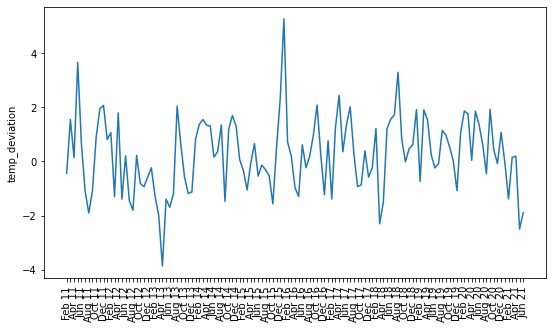

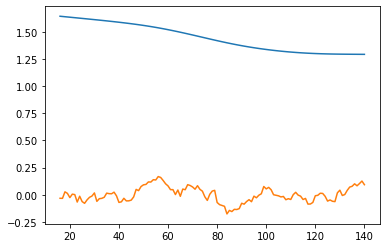

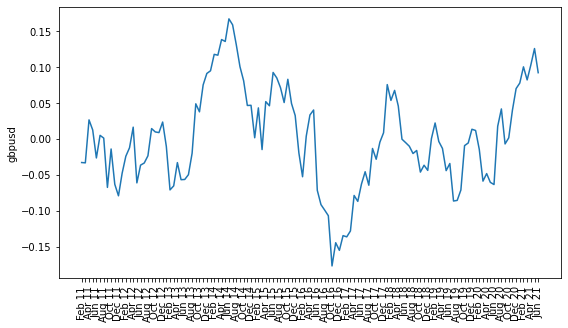

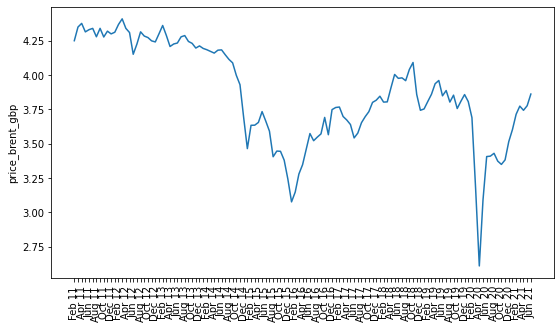

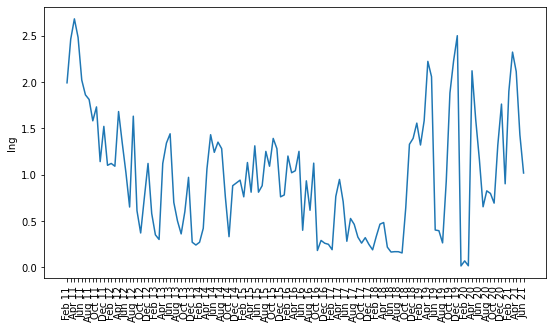

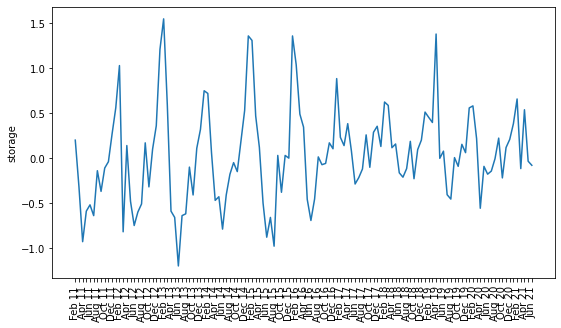

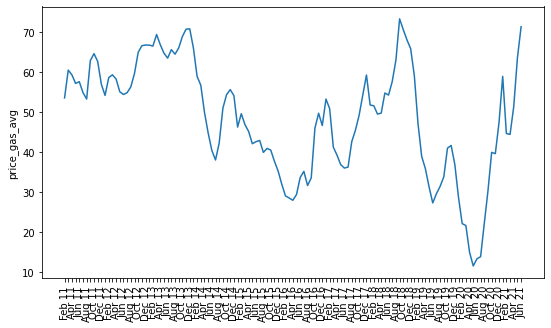

In [29]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### initiate corrected series
DataSeriesCorr=[]

#### select correction mode
TypeCorr = 'mixed' # 'HP' for filtering or 'log' or 'bothHPlog'

HP =['gbpusd', 'open_interest_gas','churn','eurgbp','gbpusd']
loga = ['price_brent_gbp','']

for df in DataSeries:

    if TypeCorr == "log" or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
            if df.name in loga:
                df_log = pd.Series(np.log(df))
                df = df_log


    if TypeCorr == 'HP' or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
        if df.name in HP or TypeCorr == 'HP':
            cycle, trend = sm.tsa.filters.hpfilter(df, 129600)
            plt.plot(trend)
            plt.plot(cycle)
            cycle.name = df.name
            df = cycle

    if TypeCorr == 'diff':
        df_diff = df.diff().dropna()
        df = df_diff

    plt.figure(figsize=(9, 5))
    if TypeCorr == 'diff':        
        plt.plot(time.iloc[1:], df)
    else: 
        plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)

df_corr = pd.concat(DataSeriesCorr,axis=1)



In [30]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-7.557939,0.000000,0.000000
gbpusd,-2.590492,0.094978,0.000000
price_brent_gbp,-2.025661,0.275436,2.000000
lng,-3.785014,0.003064,3.000000
storage,-2.794325,0.059089,11.000000
price_gas_avg,-3.418669,0.010339,13.000000


In [31]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.222119,0.100000,3.000000
gbpusd,0.123354,0.100000,6.000000
price_brent_gbp,1.006207,0.010000,6.000000
lng,0.318237,0.100000,5.000000
storage,0.247915,0.100000,5.000000
price_gas_avg,0.659521,0.017225,6.000000


In [32]:
#### EXPORT NORMALISED DATA ####


df_export = df_corr

#df_export.insert(0,'months',time)
#print(df_export)
#df_export.to_excel(r'export_normal_data.xlsx', index = False)

#df_corr.drop(columns=['months'])
#print(df_corr)

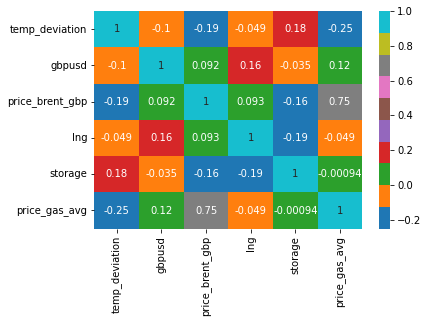

In [33]:
#### CORRELATION MATRIX ####

CorrelationMatrix=df_corr.corr()
ax=sns.heatmap(CorrelationMatrix, annot=True, cmap="tab10")


     temp_deviation    gbpusd  price_brent_gbp       lng   storage  \
16        -0.440000 -0.033052         4.248813  1.990000  0.200000   
17         1.546667 -0.033481         4.348385  2.460000 -0.320000   
18         0.138333  0.026324         4.374892  2.680000 -0.930000   
19         3.653333  0.012310         4.313090  2.480000 -0.590000   
20         0.656667 -0.026666         4.329321  2.020000 -0.520000   
..              ...       ...              ...       ...       ...   
136       -1.390000  0.100147         3.713086  1.897236  0.658246   
137        0.146667  0.081965         3.772624  2.321223 -0.116558   
138        0.188333  0.102731         3.742143  2.111904  0.538452   
139       -2.496667  0.125629         3.775441  1.428956 -0.034491   
140       -1.893333  0.092011         3.860413  1.016736 -0.079826   

     price_gas_avg  
16       53.593500  
17       60.549565  
18       59.362500  
19       57.221905  
20       57.650909  
..             ...  
136      44.

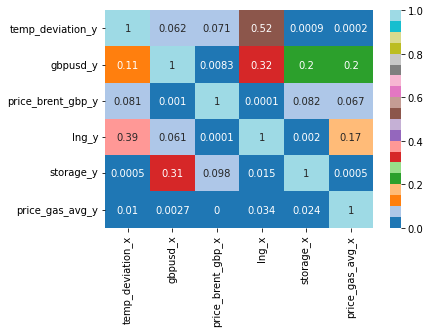

In [34]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
print(df_corr)
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


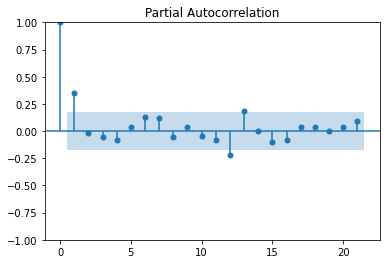

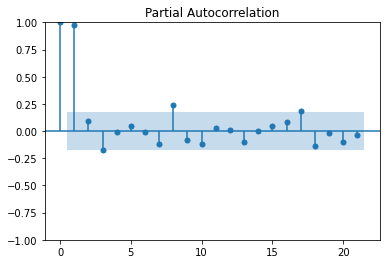

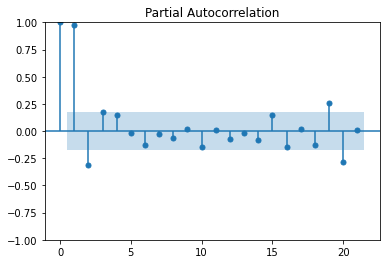

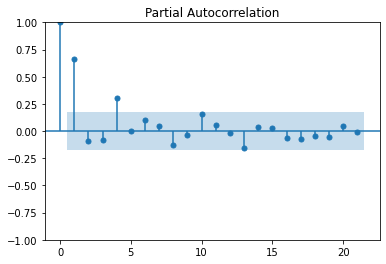

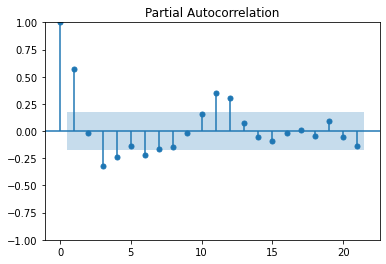

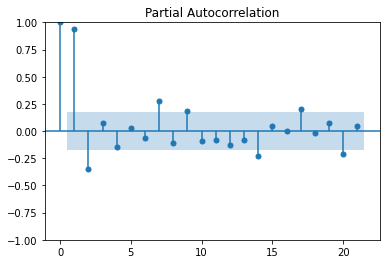

In [35]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [36]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


,AIC,BIC,FPE,HQIC
0,-4.962,-4.816,0.007000,-4.903
1,-10.76,-9.746*,2.115e-05,-10.35*
2,-10.87,-8.979,1.911e-05*,-10.10
3,-10.75,-7.987,2.178e-05,-9.632
4,-10.71,-7.066,2.345e-05,-9.229
5,-10.61,-6.098,2.688e-05,-8.781
6,-10.45,-5.062,3.378e-05,-8.264
7,-10.18,-3.922,4.842e-05,-7.644
8,-10.19,-3.057,5.472e-05,-7.298
9,-9.964,-1.955,8.209e-05,-6.715


In [37]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(6)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Aug, 2022
Time:                     19:30:47
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -5.40729
Nobs:                     119.000    HQIC:                  -8.48658
Log likelihood:          -160.906    FPE:                2.85416e-05
AIC:                     -10.5919    Det(Omega_mle):     5.62358e-06
--------------------------------------------------------------------
Results for equation temp_deviation
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      1.799065         2.013083            0.894           0.371
L1.temp_deviation          0.433316         0.113896            3.804           0.000
L1.gbpusd                 -2.47

True


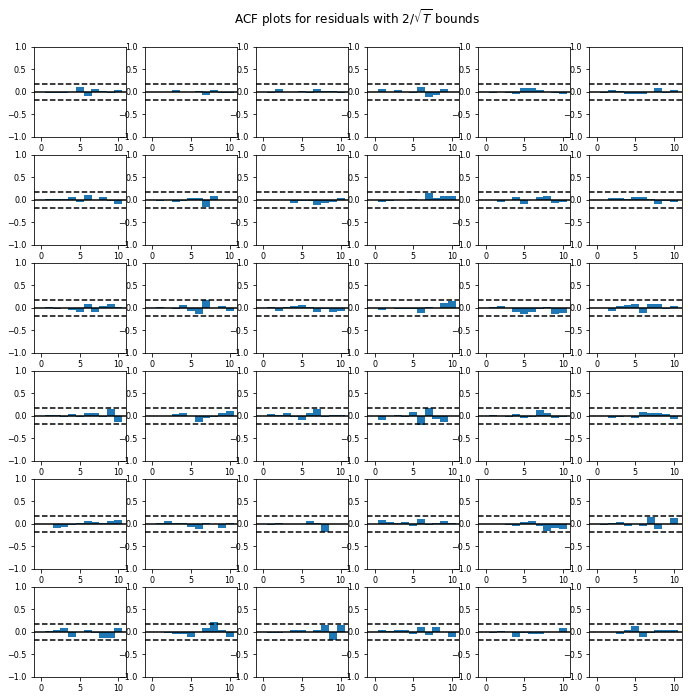

In [38]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
accor = model_fit.plot_acorr()

stab = model_fit.is_stable()
print(stab)

#if residuals out of range -> unstable model 

In [39]:
######### GRANGER CAUSALITY TEST #########
#for gas price
#GrangerCausality = model_fit.test_causality('price_gas', ['lng'], kind='f')
#print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

In [40]:
######### NORMALITY TEST #########

TestNorm = model_fit.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         33.98          21.03   0.001 12
----------------------------------------


In [41]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = model_fit.test_whiteness(nlags=18)
print(TestWhite.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 18 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         471.1          481.5   0.095 432
-----------------------------------------


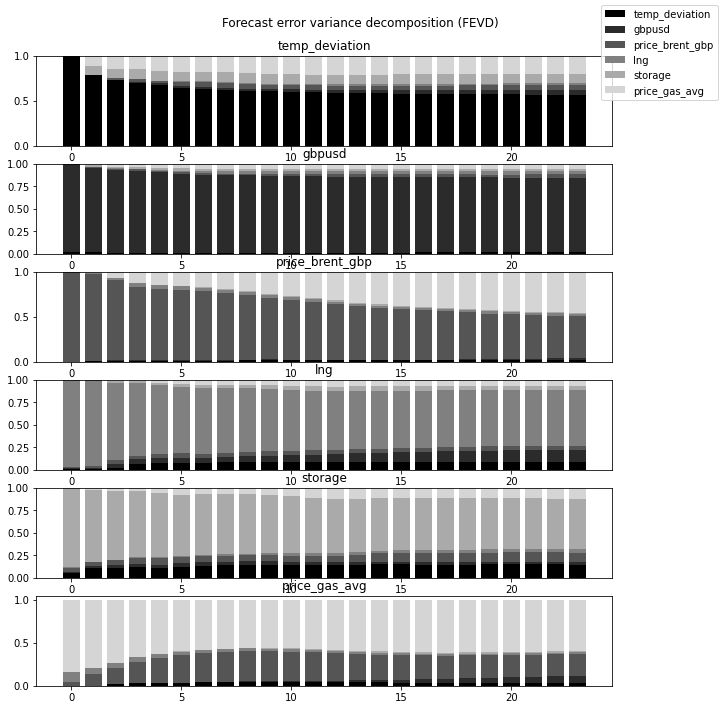

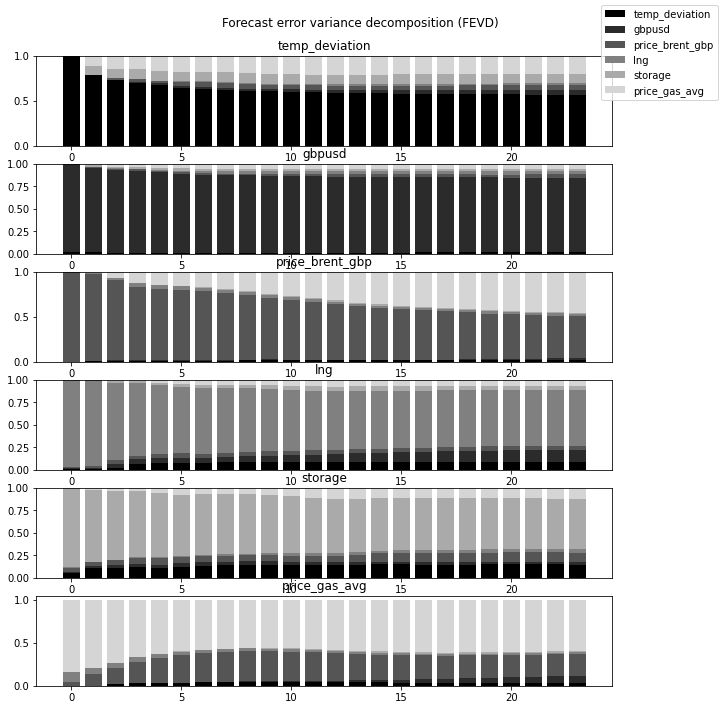

In [42]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=24
VD = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
VD.plot()

IMPULSE RESPONSE ANALYSIS:

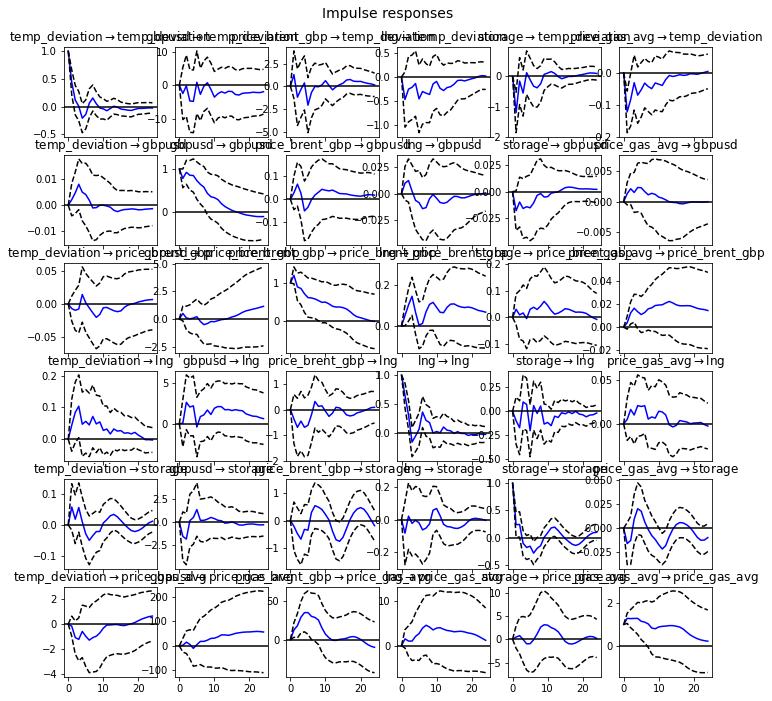

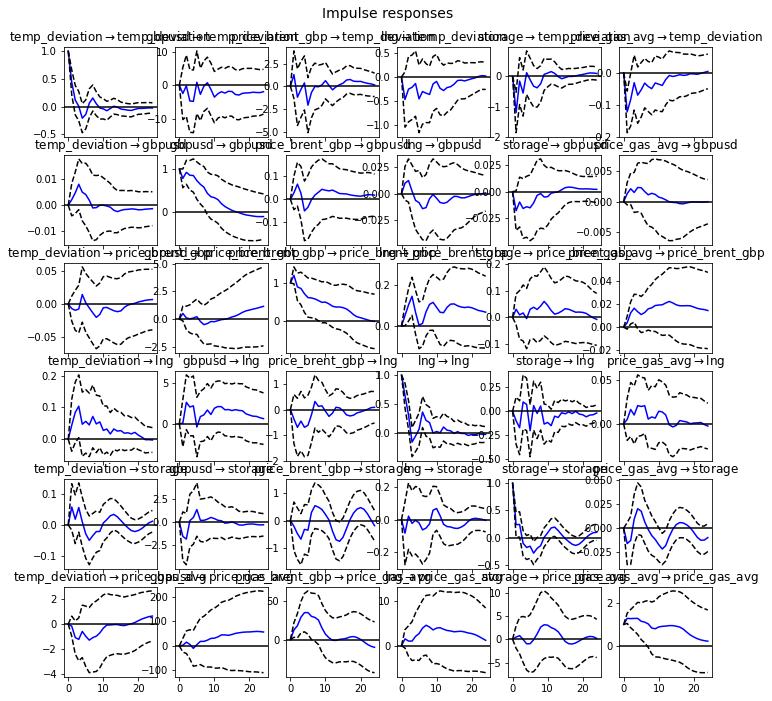

In [43]:
Impulse = model_fit.irf(24)

Impulse.plot()

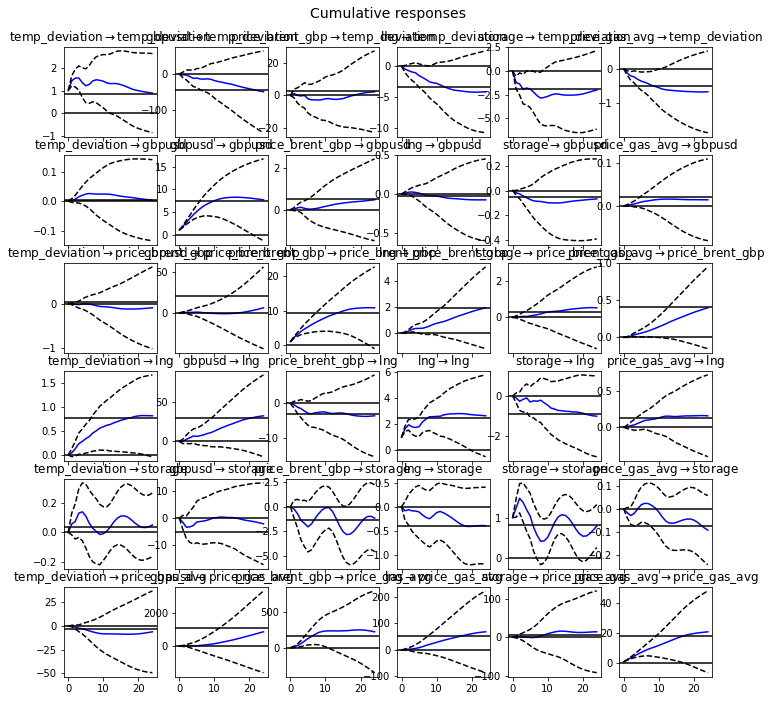

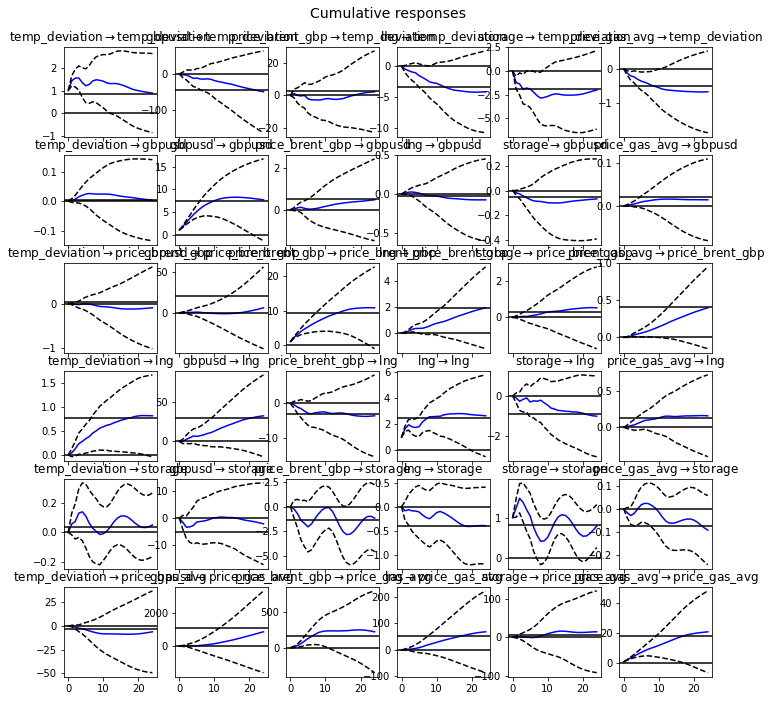

In [44]:
Impulse.plot_cum_effects(orth=False)

OTHER MODELS

In [59]:
from statsmodels.tsa.api import SVAR
 
lag_order = 2

#A = np.asarray([[0, 0, 0],['E', 0, 0],[0, 'E', 0]])
#B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])

#A = np.asarray([[1, 0, 0, 0, 0], ['E', 1, 0, 0, 'E'],['E', 0, 1, 0, 'E'],[0, 0, 'E', 1, 'E'],['E', 'E', 'E', 'E', 1]])
#A = np.asarray([['E', 0, 0, 0, 0], ['E', 'E', 'E', 'E', 'E'],['E', 'E', 'E', 0, 0],[0, 0, 0, 'E', 0],['E', 'E', 'E', 'E', 'E']]) # with temp, storage, lng, brent, price_gas
#A = np.asarray([['E',0,0,0,0,0,0], [0,'E','E',0,0,0,0],[0,'E','E',0,0,0,0],['E',0,0,'E','E',0,'E'],['E',0,'E','E','E',0,'E'],['E','E','E','E','E','E','E'],['E','E','E','E','E',0,'E']]) 
#A = np.asarray([['E', 0, 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0, 0],[0, 0, 0, 'E', 0, 0, 'E'],[0, 0, 0, 0, 'E', 0, 'E'],['E', 'E', 'E', 'E', 'E', 'E', 'E'],['E', 'E', 'E', 'E', 'E', 0, 'E']])
 # with temp, storage, lng, brent, price_gas
# A = np.asarray([['E', 0, 0, 0, 0, 0, 0], ['E', 'E', 0, 0, 0, 0, 0],['E', 'E', 'E', 0, 0, 0, 0],['E', 'E', 'E', 'E', 0, 0, 0],['E', 'E', 'E', 'E', 'E', 0, 0],['E', 'E', 'E', 'E', 'E', 'E', 0],['E', 'E', 'E', 'E', 'E', 'E', 'E']]) # with temp, usd, brent, LNG, storage, oi/churn, price_gas
A = np.asarray([['E', 0, 0, 0, 0, 0], ['E', 'E', 0, 0, 0, 0],['E', 'E', 'E', 0, 0, 0],['E', 'E', 'E', 'E', 0, 0],['E', 'E', 'E', 'E', 'E', 0],['E', 'E', 'E', 'E', 'E', 'E']]) # with temp, usd, brent, LNG, storage, price_gas

StructModel = SVAR(df_corr,svar_type='A', A=A)

#dtempdev, dstore, dlng, dprice_brent_gbp, drange

ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=10000, maxfun=10000, solver='bfgs')



/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
##### IS STABLE ? #####
Stab = ResSVAR.is_stable()
print("SVAR model is stable ? :   ",Stab)

SVAR model is stable ? :    True


In [61]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = ResSVAR.test_whiteness(nlags=24)
print(TestWhite.summary())

#Portmanteau test

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 24 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         775.0          858.6   0.660 792
-----------------------------------------


In [62]:
######### NORMALITY TEST #########

TestNorm = ResSVAR.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         196.2          21.03   0.000 12
----------------------------------------


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Pyt

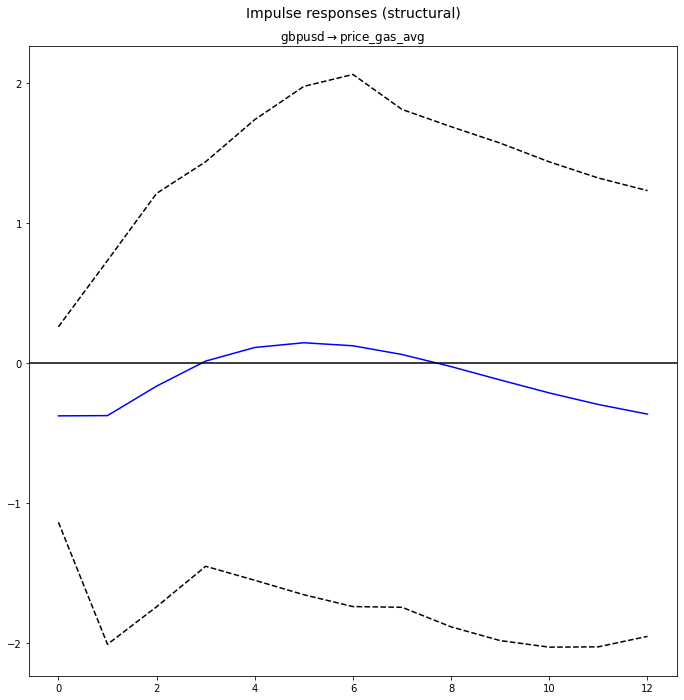

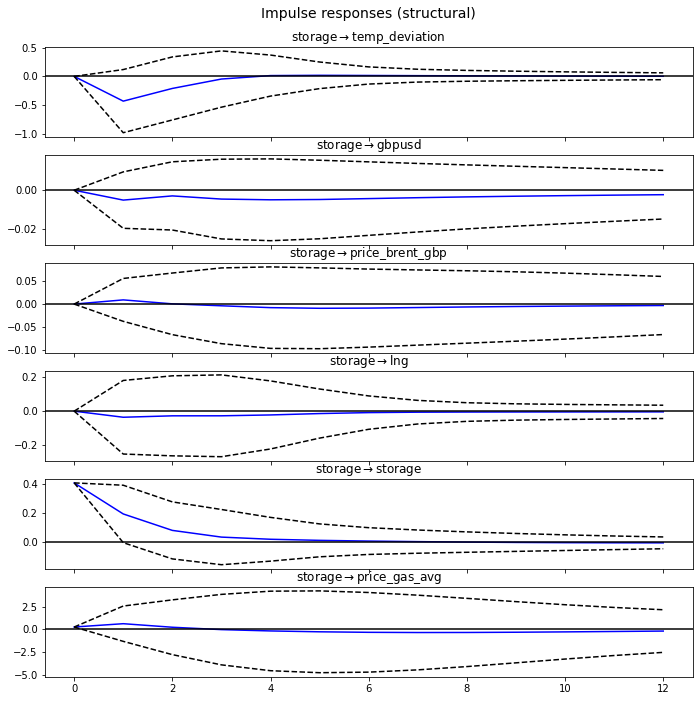

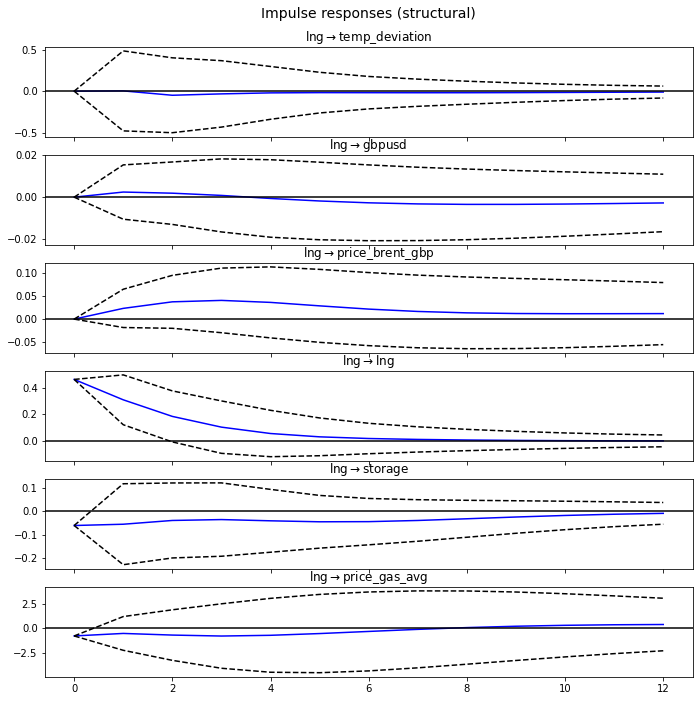

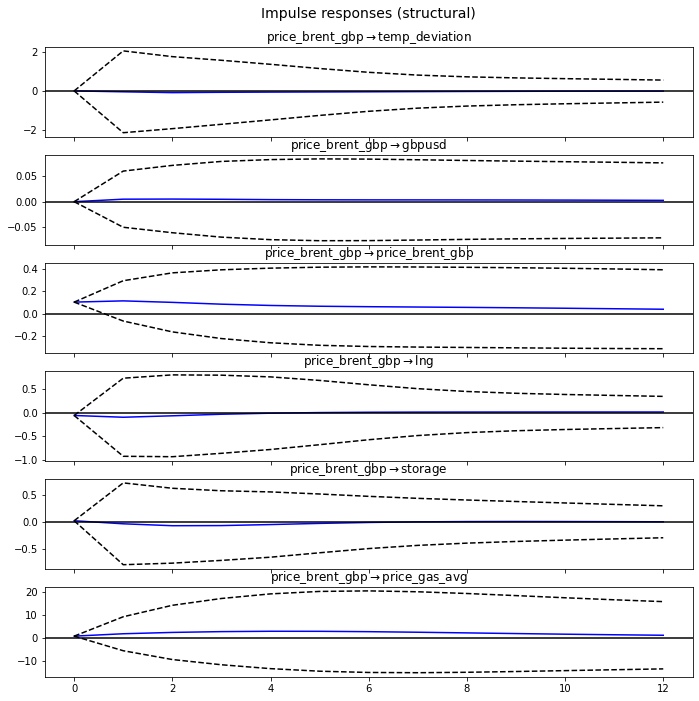

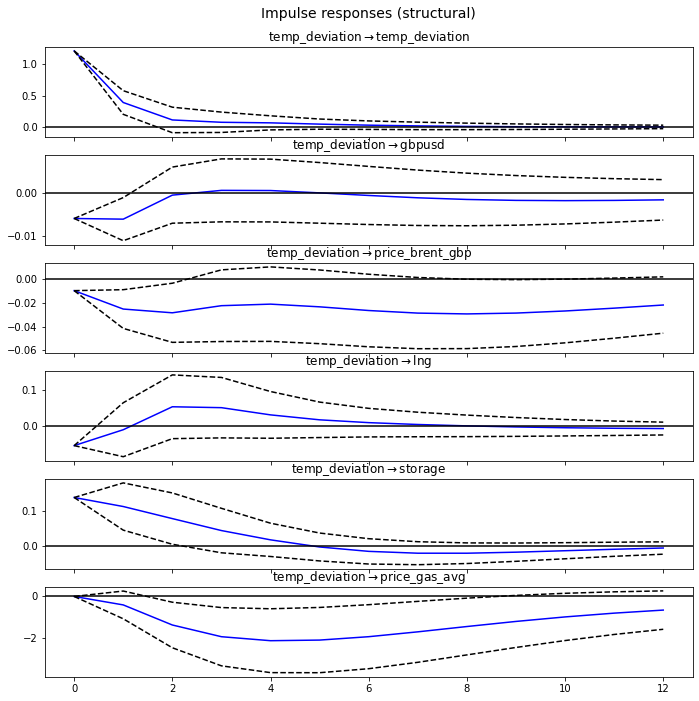

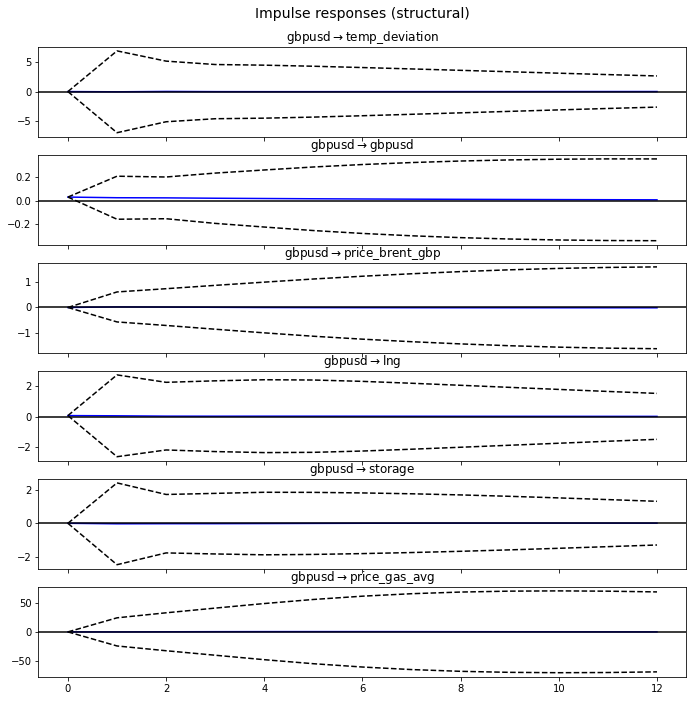

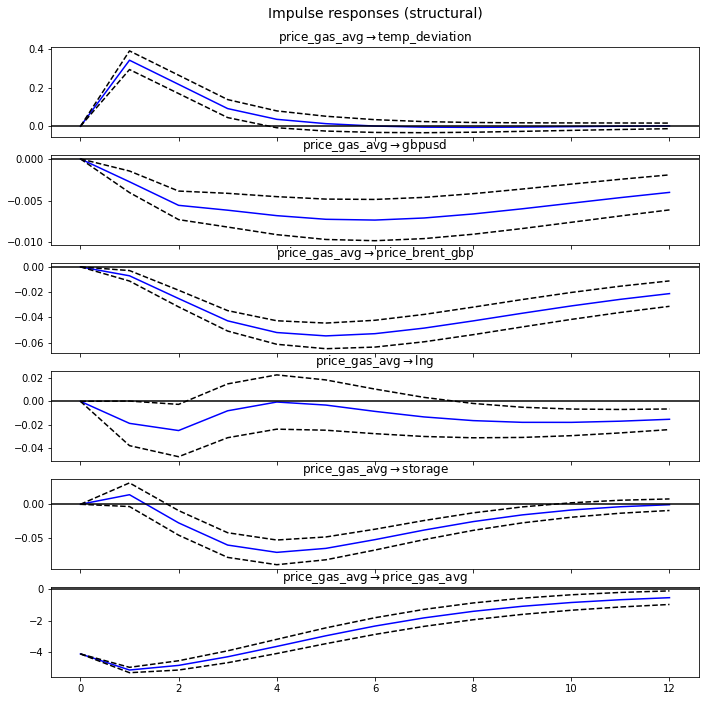

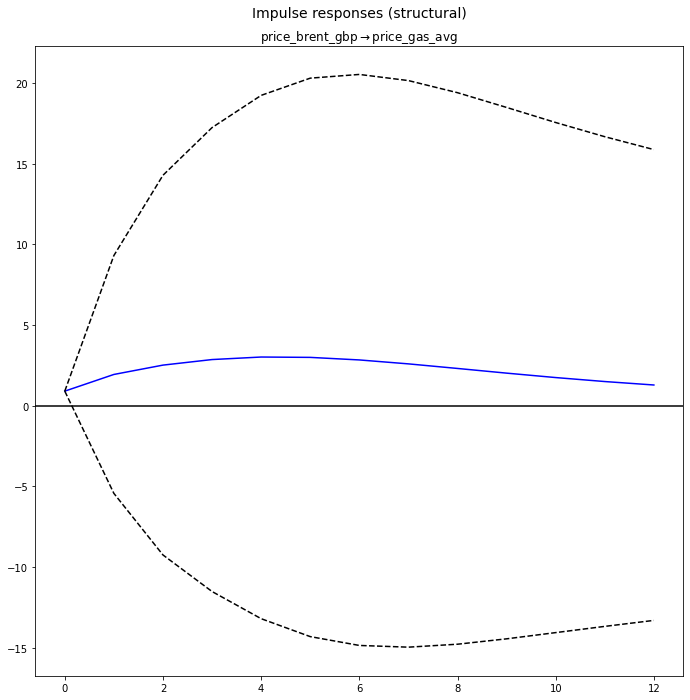

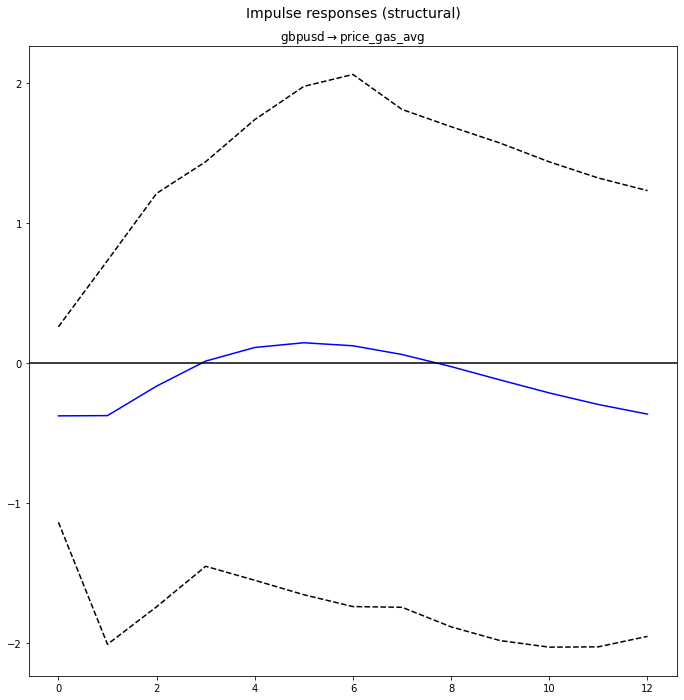

In [63]:
#### IR ####


ResSVAR.irf(periods=12).plot(impulse='storage', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='lng', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='price_brent_gbp', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='temp_deviation', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='gbpusd', plot_stderr=True,stderr_type='asym', repl=100)
#ResSVAR.irf(periods=12).plot(impulse='open_interest_gas', plot_stderr=True,stderr_type='asym', repl=100)

ResSVAR.irf(periods=12).plot(impulse='price_gas_avg', plot_stderr=True,stderr_type='asym', repl=100)


ResSVAR.irf(periods=12).plot(impulse='price_brent_gbp', response="price_gas_avg" ,plot_stderr=True, stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='gbpusd', response="price_gas_avg" ,plot_stderr=True, stderr_type='asym', repl=100)




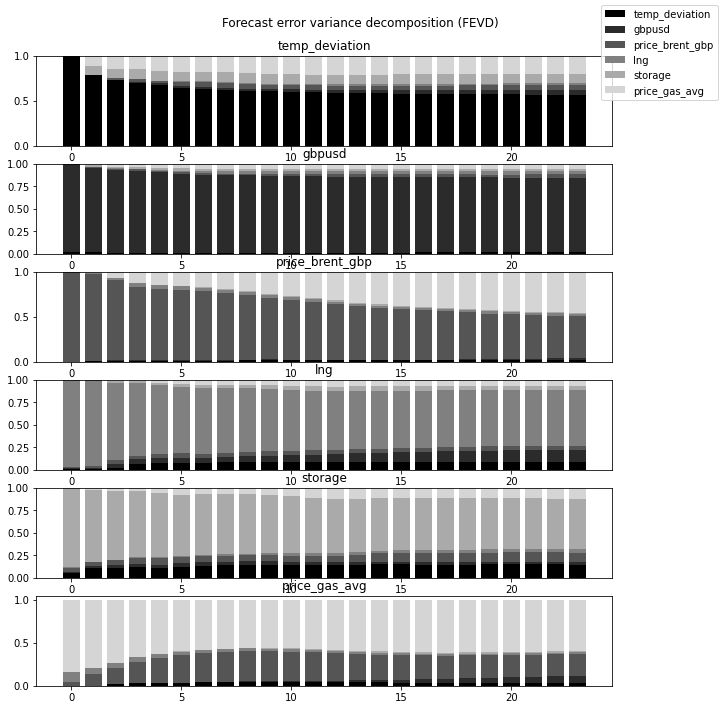

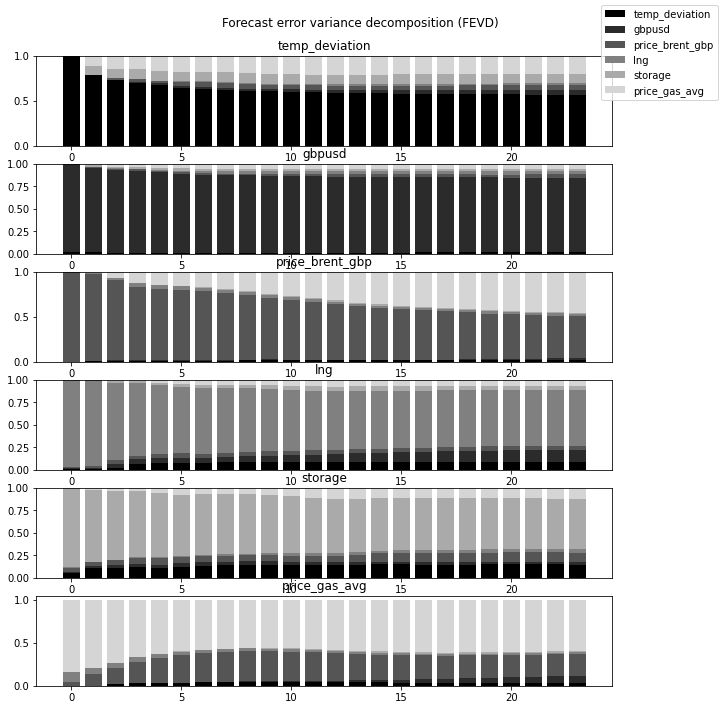

In [64]:
#### FEVD ####


#only for 20 periods
n=24
fevd = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
model_fit.fevd(n).plot()

[[-3.83333333e-02  7.75880213e-02  3.60171557e+00  9.00602300e-01
   3.84170900e-01  5.89750000e+01]
 [-1.39000000e+00  1.00147282e-01  3.71308595e+00  1.89723610e+00
   6.58245900e-01  4.46960000e+01]
 [ 1.46666667e-01  8.19645773e-02  3.77262438e+00  2.32122290e+00
  -1.16557500e-01  4.44808696e+01]
 [ 1.88333333e-01  1.02731011e-01  3.74214308e+00  2.11190430e+00
   5.38452400e-01  5.14305000e+01]
 [-2.49666667e+00  1.25629056e-01  3.77544150e+00  1.42895570e+00
  -3.44906000e-02  6.36115789e+01]
 [-1.89333333e+00  9.20113903e-02  3.86041321e+00  1.01673580e+00
  -7.98262000e-02  7.13959091e+01]]
36
[[-3.09130732e+00  7.27684417e-02  3.46687295e+00  4.42430229e-01
  -1.20029279e+00  7.77251712e+01]
 [-2.47270879e+00  4.92327697e-02  2.99877714e+00  4.45585575e-01
  -1.50006422e+00  7.81993063e+01]
 [-1.73894837e+00  2.12154983e-02  2.62105753e+00  4.60246500e-01
  -1.31760914e+00  7.71392626e+01]
 [-1.38717154e+00  3.63021150e-03  2.33556895e+00  4.58669827e-01
  -9.91468840e-01  7.

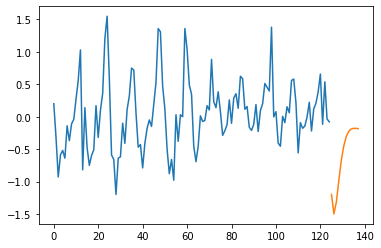

In [65]:
#### Forecast ####

#from fractions import Fraction


from numpy import linspace


yarray=df_corr.to_numpy()
#print(y)
y=yarray[119:,:]
print(y)
print(y.size)
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"

steps = 12
ForecastSVAR = ResSVAR.forecast(y,steps)

print(ForecastSVAR)
ForecastPriceGas = ForecastSVAR[:,4]

serie=yarray[:,4]
print(serie.size)
length=serie.size
xserie = np.linspace(0,length-1,length)
xforecast = np.linspace(length,length+steps,steps)

print(xserie.size)
print(xforecast.size)


print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()


137
[58.25380435 58.45380435 58.13380435 57.20380435 56.61380435 56.09380435
 55.45380435 55.31380435 54.94380435 54.83380435 54.79380435 55.06380435
 55.62380435 56.65380435 55.83380435 55.97380435 55.49380435 54.74380435
 54.14380435 53.63380435 53.80380435 53.48380435 53.58380435 53.94380435
 55.15380435 56.70380435 57.29380435 56.70380435 56.04380435 54.84380435
 54.20380435 53.58380435 53.48380435 53.07380435 53.18380435 53.50380435
 54.25380435 54.97380435 55.03380435 54.56380435 54.13380435 53.34380435
 52.93380435 52.75380435 52.70380435 52.55380435 52.74380435 53.27380435
 54.63380435 55.94380435 56.41380435 56.53380435 56.03380435 55.15380435
 54.49380435 53.51380435 53.54380435 53.16380435 53.19380435 53.19380435
 54.55380435 55.59380435 56.08380435 56.42907865 55.97081255 55.27694065
 54.8221817  54.8356719  54.76256223 54.70372153 54.87373103 54.97776423
 55.86290383 56.09483673 56.23442523 56.61784853 56.69705413 56.40901413
 56.19218573 56.07118543 56.32981643 56.2277405

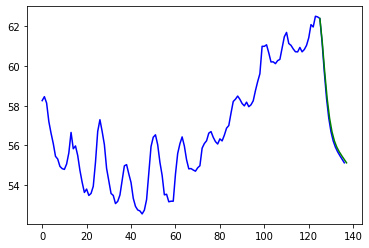

In [66]:
#### DIFF INV ####
diff_total = np.concatenate((yarray[:,4], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,4].size + steps
print(length_set)
PriceReal = np.linspace(0,length_set,length_set)
PriceReal[0] = dprice_gas.values[0]

for i in range(1,length_set):
    PriceReal[i] = diff_total[i-1] + PriceReal[i-1]

print(PriceReal)
forecasted = PriceReal[-steps:]
print(forecasted)
print(PriceReal.size)

plt.plot(PriceReal, color='blue')
plt.plot(xforecast,forecasted,color="green")
plt.show()


(array([[-3.09130732e+00,  7.27684417e-02,  3.46687295e+00,
         4.42430229e-01, -1.20029279e+00,  7.77251712e+01],
       [-2.47270879e+00,  4.92327697e-02,  2.99877714e+00,
         4.45585575e-01, -1.50006422e+00,  7.81993063e+01],
       [-1.73894837e+00,  2.12154983e-02,  2.62105753e+00,
         4.60246500e-01, -1.31760914e+00,  7.71392626e+01],
       [-1.38717154e+00,  3.63021150e-03,  2.33556895e+00,
         4.58669827e-01, -9.91468840e-01,  7.46477978e+01],
       [-1.20005162e+00, -4.80100939e-03,  2.12386211e+00,
         4.45939657e-01, -6.89296875e-01,  7.06746890e+01],
       [-1.02570236e+00, -7.90008369e-03,  1.95819678e+00,
         4.17000466e-01, -4.62394249e-01,  6.56508342e+01],
       [-8.57937104e-01, -8.66706702e-03,  1.81539761e+00,
         3.81142569e-01, -3.14886254e-01,  6.00914080e+01],
       [-7.13083759e-01, -8.68907844e-03,  1.68198470e+00,
         3.48660071e-01, -2.31758806e-01,  5.44201111e+01],
       [-5.97592799e-01, -8.75637456e-03,  1.55

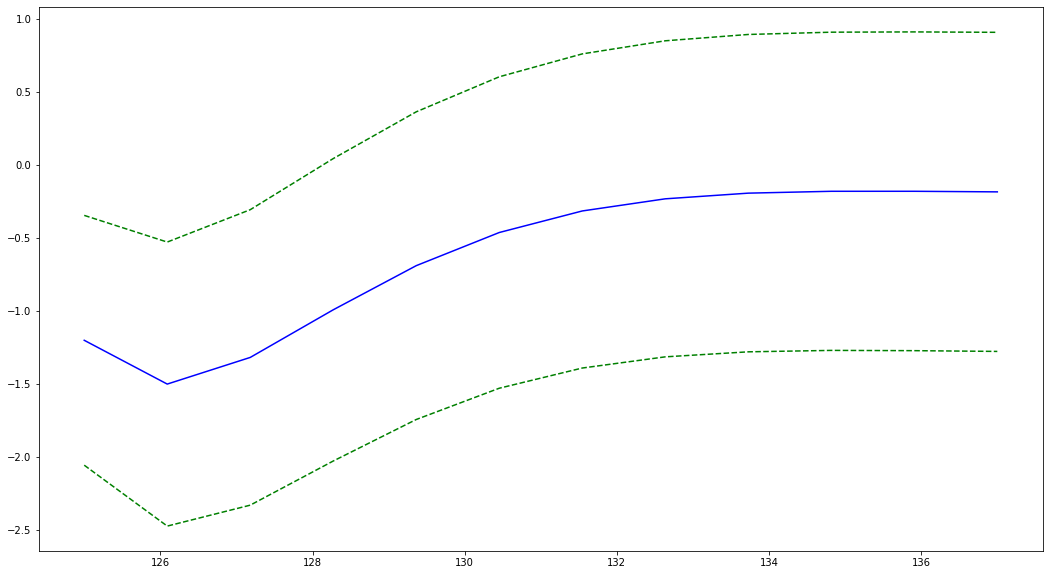

[64.14726783 61.67493599 59.3459209  57.3191479  55.5766232  54.04813119
 52.65791623 51.34428157 50.06500466 48.79552155 47.52423519 46.24774876]


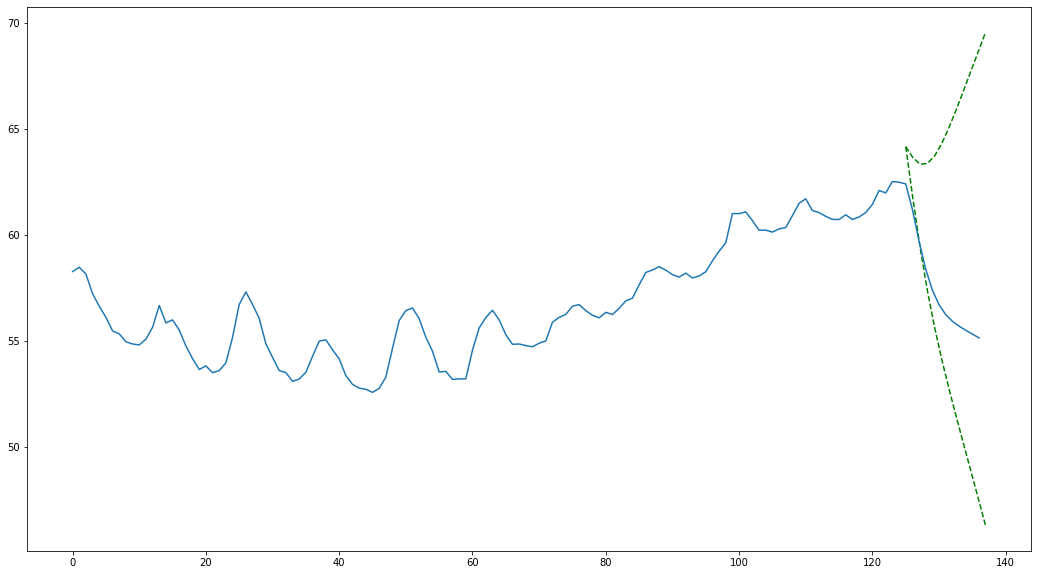

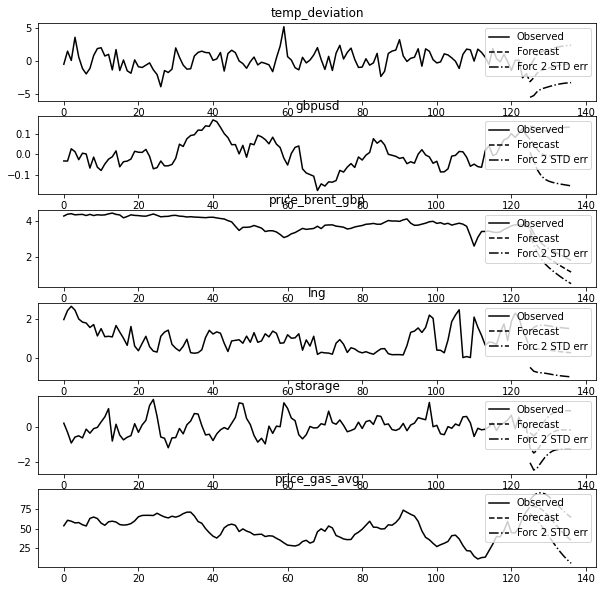

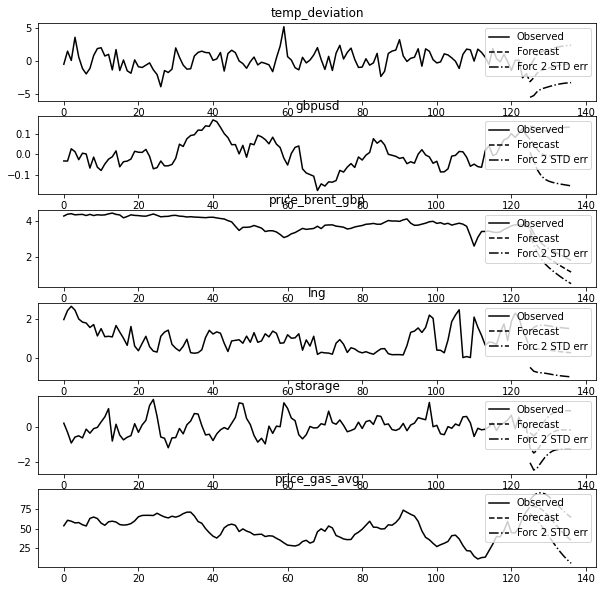

In [67]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)

# differenciated
UpBandDiff = ForecastIntSVAR[2][:,4]
LowBandDiff = ForecastIntSVAR[1][:,4]
MidDiff = ForecastIntSVAR[0][:,4]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBandDiff, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBandDiff, color="green",linestyle='dashed')
plt.plot(xforecast,MidDiff,color="blue")
plt.show()


# integrated
last_val = dprice_gas.values[-1]

UpBand = UpBandDiff
LowBand = LowBandDiff 

UpBand[0] = last_val
LowBand[0] = last_val

for i in range(1,steps):
    UpBand[i] = UpBand[i-1] + UpBandDiff[i]
    LowBand[i] = LowBand[i-1] + LowBandDiff[i]

print(LowBand)
xforecast = np.linspace(length,length+steps,steps)

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color ="green",linestyle='dashed')
plt.plot(PriceReal)
plt.show()

ResSVAR.plot_forecast(steps)

#ResSVAR.plotsim()

In [68]:
long_run = ResSVAR.test_inst_causality("lng")
long_run.summary()

Test statistic,Critical value,p-value,df
10.52,11.07,0.062,5


(array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

       [[ 1.84981800e-01, -8.10649254e+00, -1.49381803e+00,
         -6.71516437e-01, -1.54439822e+00, -1.36320762e-01],
        [-3.85464801e-03,  6.02737563e-01, -3.43636250e-03,
         -8.24575947e-03, -2.75037238e-02, -5.89734748e-04],
        [-2.61156835e-02, -1.

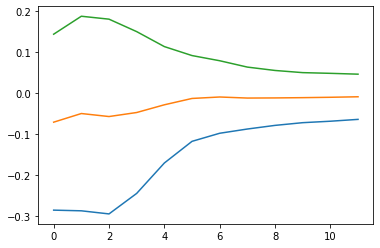

12
12
[64.14726783 62.87629129 61.32659515 59.95201467 58.9133807  58.19570755
 57.72039431 57.39613396 57.15241737 56.94785255 56.75665612 56.56642479]
64.14726783468105
[-1.2709765448045296, -1.5496961422603137, -1.3745804803017818, -1.0386339637151394, -0.71767315089409, -0.4753132469044625, -0.32426034849269814, -0.24371659016309472, -0.20456482144132646, -0.19119642743373877, -0.1902313288859755, -0.19300951680494263]
12


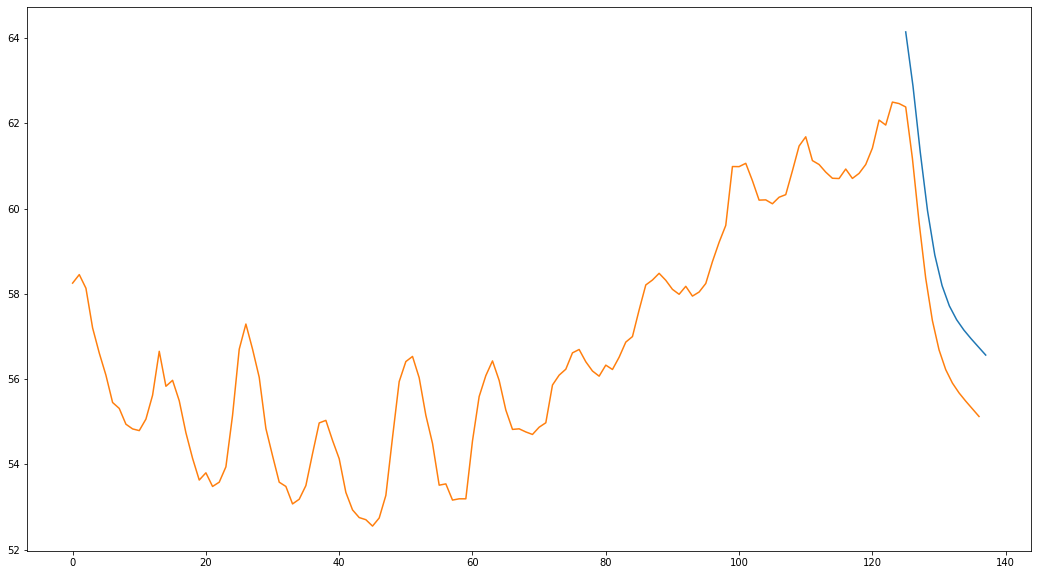

In [69]:
#### SCENARIOS FORECAST ####

ResimBand = ResSVAR.irf_errband_mc(steps=steps,cum=False) #Tuple of lower and upper arrays of ma_rep monte carlo standard errors
Resim = ResSVAR.irf_resim()
print(ResimBand)

print(ResimBand[0])
UpperBand = []
LowerBand = []
Mid = []

for i in range(1,steps+1):
    UpperBand.append(ResimBand[0][i][3][4])
    LowerBand.append(ResimBand[1][i][3][4])



print("---------------------------")
print(UpperBand)

print("---------------------------")
print(LowerBand)


for i in range(0, steps):
    Mid.append((UpperBand[i] + LowerBand[i])/2)


plt.plot(UpperBand)
plt.plot(Mid)
plt.plot(LowerBand)
plt.show()

###########################

MidDiffTot = []
diff_forecast = diff_total[-steps:]
print(len(diff_forecast))
print(len(Mid))
for i in range(0,len(Mid)):
    MidDiffTot.append(Mid[i] + diff_forecast[i])

MidImp = np.linspace(0,steps,steps)
MidImp[0] = last_val

for i in range(1,steps):
    MidImp[i] = MidImp[i-1] + MidDiffTot[i-1]

print(MidImp)
print(last_val)
print(MidDiffTot)
print(len(MidImp))
plt.figure(figsize=(18, 10))
plt.plot(xforecast,MidImp)
plt.plot(PriceReal)
plt.show()